# Inferencial Analysis of Individual Wealth Groups in South Africa

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.gettyimages.com/photos/varied-new-south-african-mandela-banknotes-with-coins-picture-id168637625?s=612x612")


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from pandas.plotting import scatter_matrix
import random
import sklearn
from IPython.display import Latex
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Hypothesis Testing

My Hypothesis is that 1) *Older* people in 2) *Gauteng* with 3) *Tertiary Education* is the subgroup that earns the highest salary.

In this inferential analysis we will observe if the above hypothesis holds. Firstly we model each feature by itself in a regression model. We then look at the effect of the combined features. An analysis of the model follows. More specifically, I analyse the F-,t-Statistics, the $R^{2}$ value, Confidence and Prediction intervals and lastly the residuals.

A hypothesis test follows. This test compares the proportions of different group, specifically the group in the hypothesis statement and the mean proportions of the distribution. The groups consist of combinations of the three features (Age, Education and Province) and the corresponding proportions of the group in each income gorup. By investigating the proportions, we can clearly observe which groups has significantly different characteristics.

### My Data

The data is collected at http://superweb.statssa.gov.za. The data is from the Labour Market Dynamics Data set that falls under the Household surveys. The data includes the amount of people that falls in a certain category. A sample of the data is shown below. I collected data from 5 years (2013 - 2017). Unfortunetly the data format differed greatly the prior years. 
-  The Regression model will use out of sample data for testing but not any form of cross validation or bootstrapping is used.
-  The Proportion hypothesis test will use a bootstrap approach.

In [3]:
pd.read_excel('Data/mixed_2017.xlsx').fillna(method = 'ffill').head(10)

,Age,Province,Education,Salary,2017
0,Age 15-19,Western Cape,No schooling,NONE,0.000000
1,Age 15-19,Western Cape,No schooling,R1 - R200,0.000000
2,Age 15-19,Western Cape,No schooling,R201 - R500,0.000000
3,Age 15-19,Western Cape,No schooling,R501 - R1 000,0.000000
4,Age 15-19,Western Cape,No schooling,R1 001 - R1 500,239.399194
5,Age 15-19,Western Cape,No schooling,R1 501 - R2 500,0.000000
6,Age 15-19,Western Cape,No schooling,R2 501 - R3 500,0.000000
7,Age 15-19,Western Cape,No schooling,R3 501 - R4 500,0.000000
8,Age 15-19,Western Cape,No schooling,R4 501 - R6 000,0.000000
9,Age 15-19,Western Cape,No schooling,R8 001 - R11 000,0.000000


In [4]:


'''
Read in the data and create a normalized dataframe as well
I also group all dataframes into a list
'''

def norm_cols(df):
    '''
    Normalizes the columns of a df
    '''
    new_df = df.copy(deep= True)
    norm_df = ((df.divide(df[df.columns].max().values,axis = 'columns'))*100).reset_index()
    norm_df = norm_df[norm_df['index'] != 'Total']
    return  new_df,norm_df


#Province Data
prov_17,prov_17n = norm_cols(pd.read_excel('Data/Province_2017.xlsx'))
prov_16,prov_16n = norm_cols(pd.read_excel('Data/Province_2016.xlsx'))
prov_15,prov_15n = norm_cols(pd.read_excel('Data/Province_2015.xlsx'))
prov_14,prov_14n = norm_cols(pd.read_excel('Data/Province_2014.xlsx'))
prov_13,prov_13n = norm_cols(pd.read_excel('Data/Province_2013.xlsx'))
#Education Data
edu_17,edu_17n = norm_cols(pd.read_excel('Data/Education_2017.xlsx'))
edu_16,edu_16n = norm_cols(pd.read_excel('Data/Education_2016.xlsx'))
edu_15,edu_15n = norm_cols(pd.read_excel('Data/Education_2015.xlsx'))
edu_14,edu_14n = norm_cols(pd.read_excel('Data/Education_2014.xlsx'))
edu_13,edu_13n = norm_cols(pd.read_excel('Data/Education_2013.xlsx'))
# Age Data
age_17,age_17n = norm_cols(pd.read_excel('Data/Age_2017.xlsx'))
age_16,age_16n = norm_cols(pd.read_excel('Data/Age_2016.xlsx'))
age_15,age_15n = norm_cols(pd.read_excel('Data/Age_2015.xlsx'))
age_14,age_14n = norm_cols(pd.read_excel('Data/Age_2014.xlsx'))
age_13,age_13n = norm_cols(pd.read_excel('Data/Age_2013.xlsx'))

# Combine all DF in one list
dfs = {'p17':prov_17,'p16':prov_16,'p15':prov_15,'p14':prov_14,'p13':prov_13,'e17':edu_17,'e16':edu_16,'e15':edu_15,'e14':edu_14,'e13':edu_13,'a17':age_17,'a16':age_16,'a15':age_15,'a14':age_14,'a13':age_13}
dfsn =  {'p17':prov_17n,'p16':prov_16n,'p15':prov_15n,'p14':prov_14n,'p13':prov_13n,'e17':edu_17n,'e16':edu_16n,'e15':edu_15n,'e14':edu_14n,'e13':edu_13n,'a17':age_17n,'a16':age_16n,'a15':age_15n,'a14':age_14n,'a13':age_13n}

sal_odr = ['NONE','R1 - R200','R201 - R500','R501 - R1 000','R1 001 - R1 500','R1 501 - R2 500','R2 501 - R3 500','R3 501 - R4 500','R4 501 - R6 000','R6 001 - R8 000','R8 001 - R11 000','R11 001 - R16 000','R16 001 - R30 000','R30 001 - R37 500','R37 501 - R54 167','R54 168 - R62 500','R62 501- R70 800','R70 801 - R83 300','R83 301 OR MORE']
sal_map = {'NONE':0,'R1 - R200':100,'R201 - R500':250,'R501 - R1 000':750,'R1 001 - R1 500':1250,'R1 501 - R2 500':2000,'R2 501 - R3 500':3000,'R3 501 - R4 500':4000,'R4 501 - R6 000':5250,'R6 001 - R8 000':7000, 'R8 001 - R11 000':9500, 'R11 001 - R16 000':13500, 'R16 001 - R30 000':22500,'R30 001 - R37 500':32500, 'R37 501 - R54 167':45000,'R54 168 - R62 500':57500,'R62 501 - R70 800':66000,'R62 501- R70 800':66000,'R70 801 - R83 300':77500,'R83 301 or more':85000,'R83 301 OR MORE':85000}


prov_17.head()

,Western Cape,Eastern Cape,Northern Cape,Free State,KwaZulu-Natal,North West,Gauteng,Mpumalanga,Limpopo,Total
R1 - R200,2124.851372,38816.538450,5464.991685,11575.652812,38080.174959,7502.428195,55864.696627,23662.457132,17819.816363,2.009116e+05
R201 - R500,9525.174007,39794.687205,3474.403027,31933.151805,66262.665841,15916.791798,110938.330616,33054.125897,41922.813839,3.528221e+05
R501 - R1 000,40345.986324,199637.442976,26090.010996,87831.238637,250120.705493,81187.670181,254977.653016,128948.497755,159810.356821,1.228950e+06
R1 001 - R1 500,48579.060881,114427.821630,15189.328676,56841.976010,192138.467231,68380.411982,257049.978793,76363.447783,116458.394396,9.454289e+05
R1 501 - R2 500,167672.208814,204587.763276,38740.603134,134135.388689,407817.026892,149616.274181,530006.309015,186562.766139,216058.620712,2.035197e+06


In [5]:
'''
Calculate the average Salary per group of the feature at hand
'''
def avgSal(df,cols):
    df = df[cols]
    df = df.reset_index()
    df = df[df['index'] != 'Total']
    df['sal'] = df['index'].map(sal_map)
    df_cols = df.columns
    avg_sal = pd.DataFrame(0, index=np.arange(1),columns=df_cols[1:])
    iterr = df.iteritems()
    next(iterr)
    for key,col in iterr:
        avg_sal[str(key)] = ((col)*(df.sal)).sum()/col.sum()
    return avg_sal.drop(columns=('sal'))




# Individual Feature Regression

Below you will see three seperate regression models that has salary as a target value. These models will not be analysed thoroughly since it will be only used to compare to the combined model.

## Provincial 
I will apply a regression model to the provincial data. The mean salary of the groups will be used as the target value and the provinces will be treated as categories.

In [6]:
'''
Calculate the avgerage salary of each province
'''
avg_prov17 = avgSal(prov_17,prov_17.columns)
avg_prov16 = avgSal(prov_16,prov_17.columns)
avg_prov15 = avgSal(prov_15,prov_17.columns)
avg_prov14 = avgSal(prov_14,prov_17.columns)
avg_prov13 = avgSal(prov_13,prov_17.columns)
avg_prov = pd.concat([avg_prov17,avg_prov16,avg_prov15,avg_prov14,avg_prov13])
avg_prov = avg_prov.melt(var_name=['Province'], value_name='avg_sal' )
avg_prov = avg_prov.sort_values(by = 'avg_sal', ascending=True)

In [7]:
'''
Generate Random vales to use in the regression model
'''
random_prov = []
random_sal = []
prov_order = ['Limpopo','KwaZulu-Natal','Free State','Eastern Cape','Northern Cape','North West','Mpumalang','Total','Western Cape','Gauteng']
prov_map = {'Limpopo':0,'KwaZulu-Natal':1,'Free State':2,'Eastern Cape':3,'Northern Cape':4,'North West':5,'Mpumalanga':6,'Total':7,'Western Cape':8,'Gauteng':9}
avg_prov['prov_mapped'] = avg_prov.Province.map(prov_map)

sequence = avg_prov.prov_mapped.unique()
for i in range(1000):
    random_prov.append( random.choice(sequence))
for i in range(1000):
    random_sal.append(random.randint(3500,10500))


No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                avg_sal   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     29.13
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           7.59e-15
Time:                        09:49:18   Log-Likelihood:                -385.48
No. Observations:                  50   AIC:                             791.0
Df Residuals:                      40   BIC:                             810.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5543.4293    

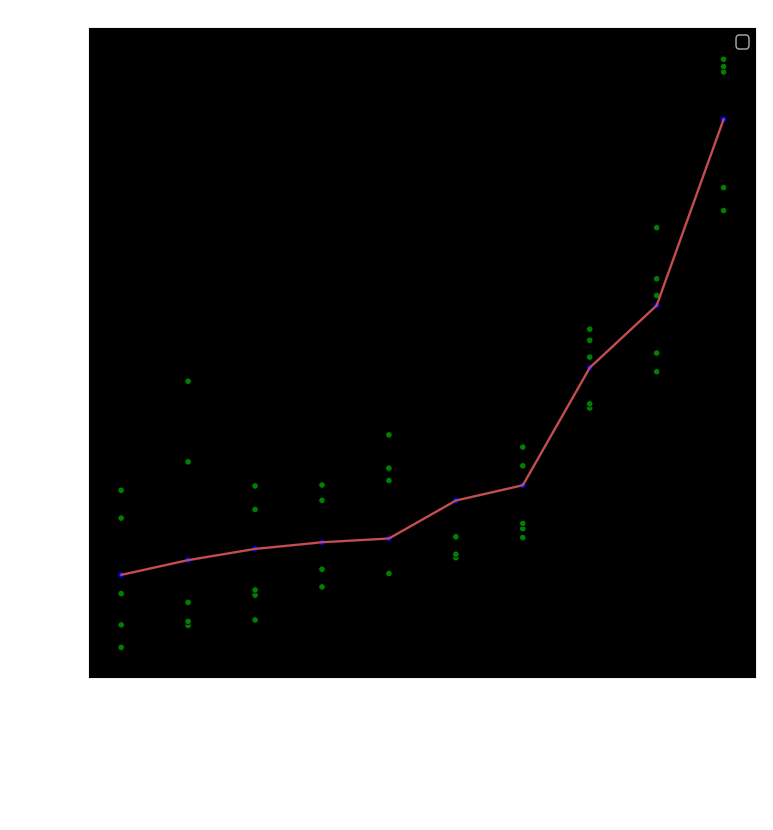

In [8]:

'''
Fit an OLS to the data
X - Province
Y - Salary
'''
fit2 = smf.ols(formula="avg_sal~C(prov_mapped)",data=avg_prov).fit()
fitted1 =pd.DataFrame( columns  = ['prov_mapped','avg_sal']) 
fitted1.prov_mapped = random_prov
fitted1['avg_sal'] = fit2.predict(fitted1['prov_mapped'])     


fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = fitted1 , x = 'prov_mapped',y = 'avg_sal', ax=ax,color = 'r').set_title('Regression on Income and Province')
sns.scatterplot(data = fitted1, x = 'prov_mapped',y = 'avg_sal',ax=ax,color = 'Blue',edgecolor = 'black',size = 0.1,legend = False)
sns.scatterplot(data = avg_prov, x = 'Province',y = 'avg_sal',ax=ax,color = 'green',edgecolor = 'black',size = 0.2,legend = False)
plt.xticks(rotation = 90)
plt.legend(loc = None)
print(fit2.summary())


We can see that 83.3% of the variance is explained by the regression model. The low $Prob( F )$ values indicate that there is a very low propability that the regression parameters are zero. In other words, the regression model does have some meaning and the data is not random. According to the F-statistic, there is indeed a difference between the mean salary of the different provinces. Province number 9 (Gauteng) has an unusually large t-value but small with regard to the standard error.

## Age
We now look at Age as a predictor of mean salary.


In [9]:
'''
Calculate the avgerage salary of each age group
print(age_17.head())
'''
def edit_ages(df):
    if 'Age 75+' in df:
        df['Age 65'] = df['Age 75+']+df['Age 70-74'] + df['Age 65-69']
        df = df.drop(columns = ['Age 75+','Age 70-74','Age 65-69'])
    else:
        df['Age 65'] = df['Age 65+']
        df = df.drop(columns = ['Total','Age 65+'])
    return df

a_age_17 = avgSal(edit_ages(age_17),edit_ages(age_17).columns)
a_age_16 = avgSal(edit_ages(age_16),edit_ages(age_16).columns)
a_age_15 = avgSal(edit_ages(age_15),edit_ages(age_15).columns)
a_age_14 = avgSal(edit_ages(age_14),edit_ages(age_14).columns)
a_age_13 = avgSal(edit_ages(age_13),edit_ages(age_13).columns)


In [10]:
'''
Melt the data fram to a sparse reresentation and convert age to float
'''
avg_age = pd.concat([a_age_17,a_age_16,a_age_15,a_age_14,a_age_13])
avg_age = avg_age.melt(var_name=['Age'], value_name='avg_sal' )
avg_age = avg_age.sort_values(by = 'avg_sal', ascending=True)
avg_age = avg_age[avg_age.Age != 'Total']
avg_age['Age'] = avg_age.Age.apply(lambda x: float(x[-2:]))


No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                avg_sal   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     375.6
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           1.02e-25
Time:                        09:49:19   Log-Likelihood:                -435.62
No. Observations:                  55   AIC:                             875.2
Df Residuals:                      53   BIC:                             879.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2578.1302    277.032      9.306      0.0

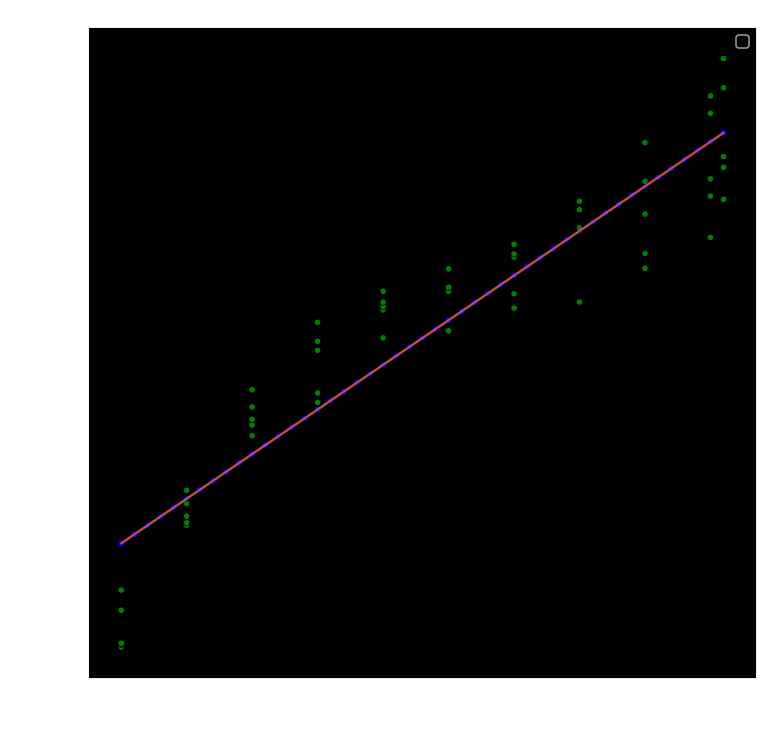

In [11]:

'''
Fit an OLS to the data
X - Age
Y - Salary
'''
fit_age = smf.ols(formula = 'avg_sal ~ Age',data = avg_age).fit()
ols_data = pd.DataFrame(columns=['Age','avg_sal'])
ols_data['Age']= [random.randint(19, 65) for x in range(1000) ]
ols_data['avg_sal'] = fit_age.predict(ols_data.Age)

fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = ols_data , x = 'Age',y = 'avg_sal', ax=ax,color = 'r').set_title('Regression on Age and Income')
sns.scatterplot(data = ols_data, x = 'Age',y = 'avg_sal',ax=ax,color = 'Blue',edgecolor = 'black',size = 0.1,legend = False)
sns.scatterplot(data = avg_age, x = 'Age',y = 'avg_sal',ax=ax,color = 'green',edgecolor = 'black',size = 0.2,legend = False)
plt.xticks(rotation = 90)
plt.legend(loc = None)
print(fit_age.summary())

We observe an even larger $R^{2}$ value. According to the F-statistic, there is indeed a difference between the mean salary of the different age groups. We can visually confirm this. We see a large t-value compared to the standard error for Age.

## Education

Lastly we look at Education level as a predictor. I will treat the education level as a category.

In [12]:
'''
Calculate the avgerage salary of each education group
'''

a_edu_17 = avgSal(edu_17,edu_17.columns)
a_edu_16 = avgSal(edu_16,edu_16.columns)
a_edu_15 = avgSal(edu_15,edu_15.columns)
a_edu_14 = avgSal(edu_14,edu_14.columns)
a_edu_13 = avgSal(edu_13,edu_13.columns)


In [13]:
'''
Melt the data fram to a sparse reresentation and convert education to categorical
'''
edu_map = {'No schooling':0, 'Less than primary completed':1,'Secondary not completed':3, 'Secondary completed':4, 'Tertiary':5, 'Primary completed':2, 'Total':10}
avg_edu = pd.concat([a_edu_17,a_edu_16,a_edu_15,a_edu_14,a_edu_13])
avg_edu = avg_edu.melt(var_name=['edu'], value_name='avg_sal' )
avg_edu = avg_edu.sort_values(by = 'avg_sal', ascending=True)
avg_edu['education'] = avg_edu.edu.map(edu_map)
avg_edu = avg_edu[avg_edu.edu != 'Total']
avg_edu['education'] = avg_edu.education.apply(lambda x: int(x))


No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                avg_sal   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     483.7
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           2.90e-23
Time:                        09:49:19   Log-Likelihood:                -227.76
No. Observations:                  30   AIC:                             467.5
Df Residuals:                      24   BIC:                             475.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2877.7134    239.84

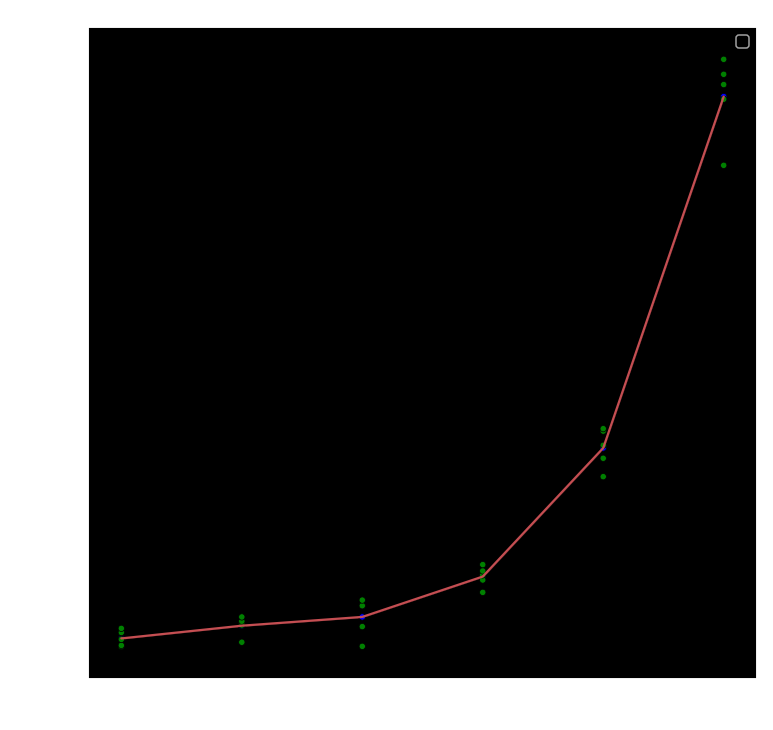

In [14]:

'''
Fit an OLS to the data
X - Education
Y - Salary
'''


fit_edu = smf.ols(formula="avg_sal~C(education)",data=avg_edu).fit()
ols_edu =pd.DataFrame( columns  = ['education','avg_sal']) 
random_edu = [random.randint(0, 5) for x in range(100) ]
ols_edu.education = random_edu
ols_edu['avg_sal'] = fit_edu.predict(ols_edu['education'])     


fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = ols_edu , x = 'education',y = 'avg_sal', ax=ax,color = 'r').set_title('Regression on Education level and Income')
sns.scatterplot(data = ols_edu, x = 'education',y = 'avg_sal',ax=ax,color = 'Blue',edgecolor = 'black',size = 0.1,legend = False)
sns.scatterplot(data = avg_edu, x = 'education',y = 'avg_sal',ax=ax,color = 'green',edgecolor = 'black',size = 0.2,legend = False)
plt.xticks(rotation = 90)
plt.legend(loc = None)
print(fit_edu.summary())

By looking at the $R^{2}$ value of 98,8%, this model can very accuretly predict the mean salary. Almost all of the variation present in the model can be explained by the education level. According to the very low F-statistic, there is indeed a difference between the mean salary of the different education groups. Education level seems like the best predictor of income.

# Combine Model

Now that we saw how the features perform seperatly it is time to combine them. Although education level as a sole predictor performed very well, the purpose of this analysis is not to predict the mean salary of a group of individuals but rather to verify my hypothesis of the combined features. 

The following regression model consists of **Education** , **Age** and **Province**. Salary will be the target value as before. The plots of the individual features including the regression results will be displayed. After modelling, the F-Statistic, t-Statistic, R-Squared , Confidence Intervals, Prediction Intervals and Residuals will be analysed and discussed to verify that the model is optimal and evaluate its performance. I hope to see an optimal model where the subgroup of **older** people in **Gauteng** with a **tertiary** education provides the most significant results.

The following table shows the categorical mappings used for the Provinces and Education levels.

| Province      | Province Mapped | Education Level               | Education Mapped |
|---------------|-----------------|-------------------------------|------------------|
| Limpopo       | 0               |   *No schooling*                | 0                |
| KwaZulu-Natal | 1               |   *Less than primary completed* | 1                |
| Free State    | 2               |   *Primary completed*           | 2                |
| Eastern Cape  | 3               | *Secondary not completed*     | 3                |
| Northern Cape | 4               | *Secondary completed*         | 4                |
| North West    | 5               | *Tertiary*                    | 5                |
| Mpumalanga    | 6               |                           
| Western Cape  | 7               |                           
| Gauteng       | 8               |                           

In [15]:
def format_mix(df):
    '''
    Format the data by removing the totals
    '''
    df = df[df.Age != 'Total']
    df = df[df.Salary != 'Total']
    df = df[df.Province != 'Total']
    df = df[df.Education != 'Total']
    df.Salary = df.Salary.map(sal_map)

    df.Age.loc[df.Age == 'Age 65+'] = '65'
    df.Age = df.Age.apply(lambda x : int(x[-2:]))
    
    return df


In [16]:
mix_17 = format_mix(pd.read_excel('Data/mixed_2017.xlsx').fillna(method = 'ffill'))
mix_16 = format_mix(pd.read_excel('Data/mixed_2016.xlsx').fillna(method = 'ffill'))
mix_15 = format_mix(pd.read_excel('Data/mixed_2015.xlsx').fillna(method = 'ffill'))
mix_14 = format_mix(pd.read_excel('Data/mixed_2014.xlsx').fillna(method = 'ffill'))
mix_13 = format_mix(pd.read_excel('Data/mixed_2013.xlsx').fillna(method = 'ffill'))


In [17]:
'''
Format the dataframes to suite my problem
'''


mix = pd.concat([mix_17,mix_16,mix_15,mix_14,mix_13])
mix = mix.melt(id_vars = ['Age','Education','Province','Salary'],var_name = ['year'])

mix['salXcount'] = mix['Salary']*mix['value']
groups = mix.groupby(by= ['Age','Province','Education','year']).sum().reset_index()

groups['avg_sal'] = groups['salXcount']/groups['value']
groups = groups.dropna()
groups = groups.drop(columns = ['value','salXcount','Salary'])
groups.head(10)
'''
Categorize the Provinces and Education levels
'''
prov_map = {'Limpopo':1,'KwaZulu-Natal':2,'Free State':3,'Eastern Cape':4,'Northern Cape':5,'North West':6,'Mpumalanga':7,'Western Cape':8,'Gauteng':9}
edu_map = {'No schooling':1, 'Less than primary completed':2,'Secondary not completed':4, 'Secondary completed':5, 'Tertiary':6, 'Primary completed':3}
groups['edu_cat'] = groups.Education.map(edu_map)
groups['prov_cat'] = groups.Province.map(prov_map)

### A quick Visualization of Age, Education and Mean Salary

Text(0.5,1,'Swarmplot of Age , Education and Salary')

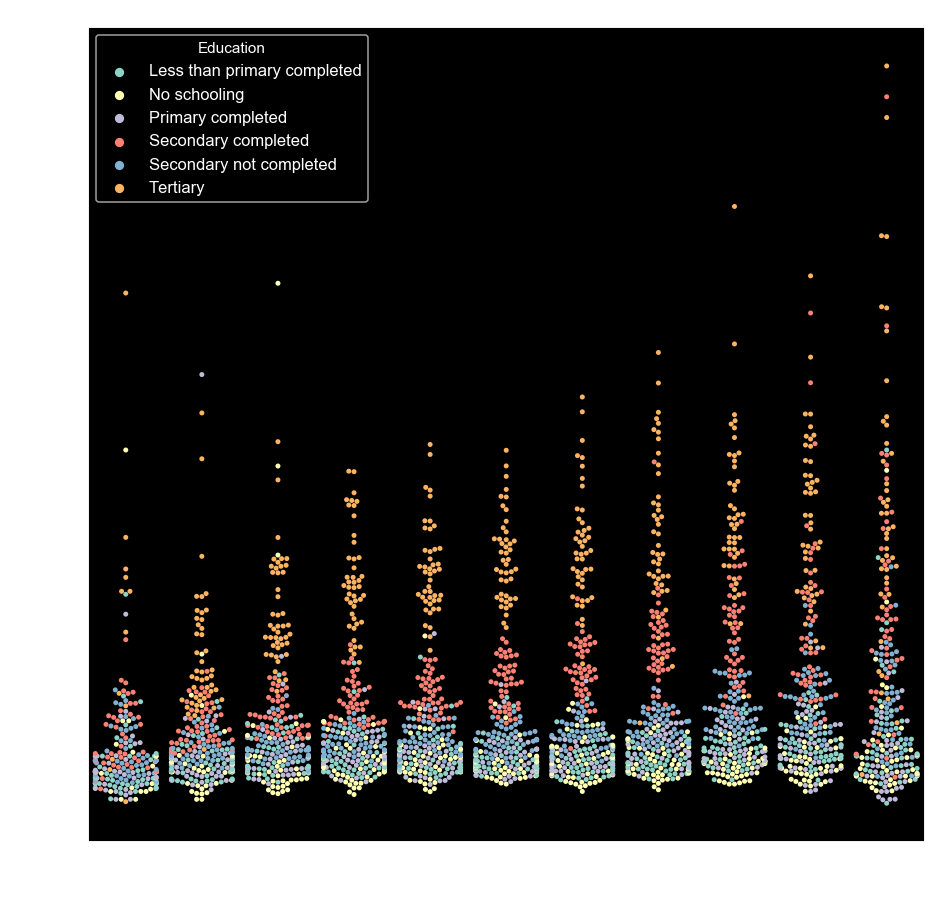

In [18]:

plt.figure(figsize = (15,15))
sns.swarmplot(data = groups , y = 'avg_sal',x = 'Age',edgecolor = 'black',hue = 'Education').set_title('Swarmplot of Age , Education and Salary')



In [19]:
'''
Construct the model and calculate the confidence and prediction intervals
'''

mix_fit = smf.ols(formula = 'avg_sal ~ Age + C(edu_cat) + C(prov_cat)',data =  groups).fit()


age_ran = []
edu_ran = []
prov_ran = []
ages = [19,24,29,34,39,44,49,54,59,65,65]

for i in range(1000):
    age_ran.append(random.choice(ages))
    edu_ran.append(random.randint(1,6))
    prov_ran.append(random.randint(1,9))
mix_random = pd.DataFrame(columns=['Age','avg_sal','edu_cat','prov_cat'])
mix_random.Age = age_ran
mix_random.prov_cat = prov_ran
mix_random.edu_cat = edu_ran


mix_random.avg_sal = mix_fit.predict(mix_random)
m = mix_fit.get_prediction(mix_random)
mix_random['ci_lower'] = m.summary_frame(alpha = 0.05)['mean_ci_lower']
mix_random['ci_upper'] = m.summary_frame(alpha = 0.05)['mean_ci_upper']
mix_random['o_ci_lower'] = m.summary_frame(alpha = 0.05)['obs_ci_lower']
mix_random['o_ci_upper'] = m.summary_frame(alpha = 0.05)['obs_ci_upper']



#### Table of the Prediction and Confidence ontervals of $\alpha = 0.05$

In [20]:
m.summary_frame(alpha = 0.95).head(10)


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,257.118060,231.772308,242.583100,271.653020,64.514299,449.721821
1,2359.320323,212.361347,2346.002668,2372.637979,2166.804601,2551.836046
2,14412.283464,215.490070,14398.769599,14425.797328,14219.754068,14604.812859
3,5398.304511,232.469970,5383.725799,5412.883223,5205.697443,5590.911578
4,2222.151281,214.417980,2208.704650,2235.597912,2029.626593,2414.675969
5,5671.527623,227.104813,5657.285372,5685.769874,5478.945731,5864.109516
6,8836.901005,211.979129,8823.607319,8850.194690,8644.386939,9029.415071
7,7401.642509,226.567077,7387.433981,7415.851037,7209.063108,7594.221911
8,3504.046002,214.104408,3490.619035,3517.472968,3311.522686,3696.569317
9,2981.543745,214.107851,2968.116562,2994.970927,2789.020414,3174.067075


#### Regression visualisation of Age

The green lines indicate the prediction intervals where the blue lines indicate the confidence intervals

(array([10., 20., 30., 40., 50., 60., 70.]),
 <a list of 7 Text xticklabel objects>)

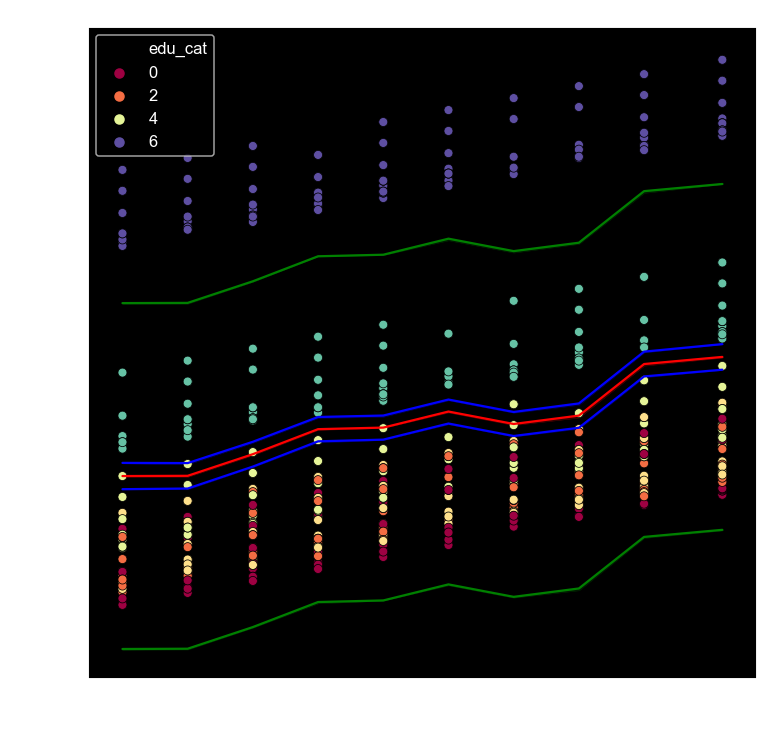

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = mix_random,x = 'Age',y = 'avg_sal',ax = ax,color = 'red',ci = 0).set_title('Salary vs Age')
sns.lineplot(data = mix_random,x = 'Age',y = 'ci_lower',ax = ax,color = 'Blue',ci = 0)
sns.lineplot(data = mix_random,x = 'Age',y = 'ci_upper',ax = ax,color = 'Blue',ci = 0)
sns.lineplot(data = mix_random,x = 'Age',y = 'o_ci_lower',ax = ax,color = 'green',ci = 0)
sns.lineplot(data = mix_random,x = 'Age',y = 'o_ci_upper',ax = ax,color = 'green',ci = 0)

sns.scatterplot(data = mix_random , y = 'avg_sal',x = 'Age',edgecolor = 'black',hue = 'edu_cat',ax = ax,palette = 'Spectral')
plt.xticks(rotation = 90)


#### Regression visualisation of Education Level

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text xticklabel objects>)

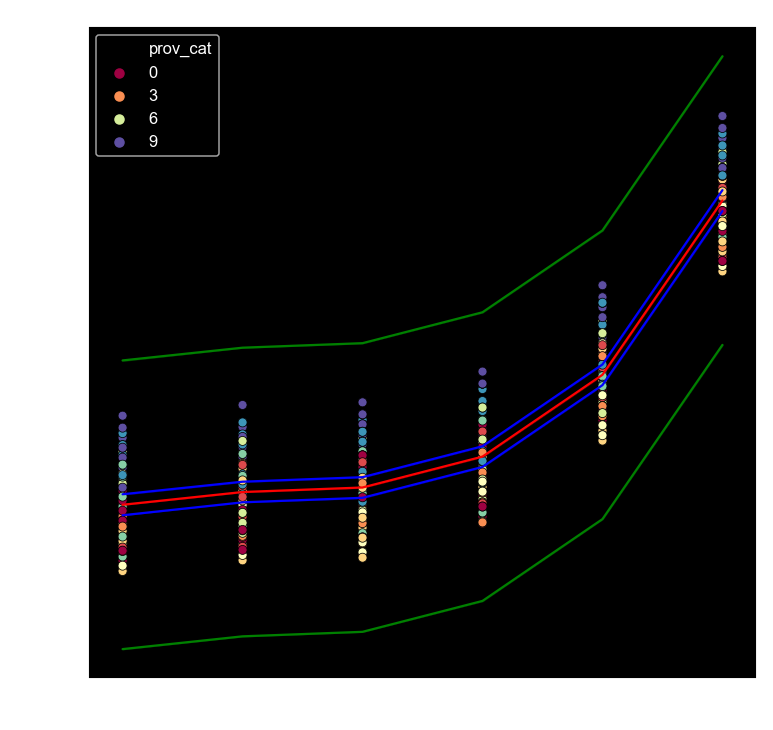

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = mix_random,x = 'edu_cat',y = 'avg_sal',ax = ax,color = 'red',ci = 0).set_title('Salary vs Education')
sns.lineplot(data = mix_random,x = 'edu_cat',y = 'ci_lower',ax = ax,color = 'Blue',ci = 0)
sns.lineplot(data = mix_random,x = 'edu_cat',y = 'ci_upper',ax = ax,color = 'Blue',ci = 0)

sns.lineplot(data = mix_random,x = 'edu_cat',y = 'o_ci_lower',ax = ax,color = 'green',ci = 0)
sns.lineplot(data = mix_random,x = 'edu_cat',y = 'o_ci_upper',ax = ax,color = 'green',ci = 0)

sns.scatterplot(data = mix_random , y = 'avg_sal',x = 'edu_cat',edgecolor = 'black',hue = 'prov_cat',ax = ax,palette = 'Spectral')

plt.xticks(rotation = 90)


#### Regression visualisation of Province

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 11 Text xticklabel objects>)

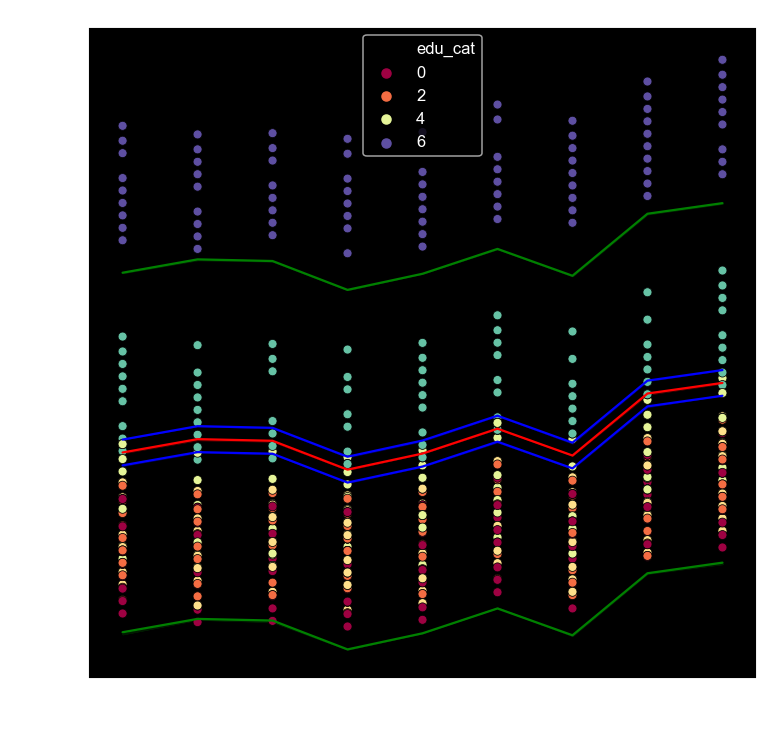

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(data = mix_random,x = 'prov_cat',y = 'avg_sal',ax = ax,color = 'red',ci = 0).set_title('Salary vs Province')

sns.lineplot(data = mix_random,x = 'prov_cat',y = 'ci_lower',ax = ax,color = 'Blue',ci = 0)
sns.lineplot(data = mix_random,x = 'prov_cat',y = 'ci_upper',ax = ax,color = 'Blue',ci = 0)
sns.lineplot(data = mix_random,x = 'prov_cat',y = 'o_ci_lower',ax = ax,color = 'green',ci = 0)
sns.lineplot(data = mix_random,x = 'prov_cat',y = 'o_ci_upper',ax = ax,color = 'green',ci = 0)

sns.scatterplot(data = mix_random.sort_values(by = 'prov_cat') , y = 'avg_sal',x = 'prov_cat',edgecolor = 'black',hue = 'edu_cat',ax = ax,palette = 'Spectral')
plt.xticks(rotation = 90)


#### Below is the results of the regression followed by the influence of the regressors

In [24]:
print(mix_fit.summary())
mix_fit.get_influence().summary_frame().tail()

                            OLS Regression Results                            
Dep. Variable:                avg_sal   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     478.7
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        09:49:25   Log-Likelihood:                -27367.
No. Observations:                2898   AIC:                         5.476e+04
Df Residuals:                    2883   BIC:                         5.485e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1338.0072    274.888  

,dfb_Intercept,dfb_C(edu_cat)[T.2],dfb_C(edu_cat)[T.3],dfb_C(edu_cat)[T.4],dfb_C(edu_cat)[T.5],dfb_C(edu_cat)[T.6],dfb_C(prov_cat)[T.2],dfb_C(prov_cat)[T.3],dfb_C(prov_cat)[T.4],dfb_C(prov_cat)[T.5],...,dfb_C(prov_cat)[T.7],dfb_C(prov_cat)[T.8],dfb_C(prov_cat)[T.9],dfb_Age,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
2965,-0.115248,0.004289,0.004721,0.004918,0.004967,0.193518,-0.001299,-0.001137,-0.000233,-0.001515,...,0.000038,0.232342,-0.000956,0.148730,0.012793,0.440653,0.438055,0.005472,5.905453,5.940468
2966,-0.023640,0.000880,0.000968,0.001009,0.001019,0.039694,-0.000266,-0.000233,-0.000048,-0.000311,...,0.000008,0.047658,-0.000196,0.030508,0.000545,0.090387,0.090379,0.005472,1.218411,1.218513
2967,-0.026842,0.000999,0.001100,0.001145,0.001157,0.045072,-0.000303,-0.000265,-0.000054,-0.000353,...,0.000009,0.054114,-0.000223,0.034640,0.000702,0.102631,0.102615,0.005472,1.383359,1.383578
2968,0.003677,-0.000137,-0.000151,-0.000157,-0.000159,-0.006175,0.000041,0.000036,0.000007,0.000048,...,-0.000001,-0.007414,0.000030,-0.004746,0.000013,-0.014061,-0.014063,0.005472,-0.189584,-0.189553
2969,-0.039845,0.001483,0.001632,0.001700,0.001717,0.066906,-0.000449,-0.000393,-0.000081,-0.000524,...,0.000013,0.080328,-0.000330,0.051421,0.001546,0.152348,0.152264,0.005472,2.052675,2.053820


#### Adjusted $R^{2} = 0.698$

The value is much lower than expected. There is alot of variance in the model that is not explained by the regressors

#### $F$-Statistic and $P$-value

$$
    H_{0} : \beta_{0}=\beta_{1}=\beta_{2}...=\beta_{n-1}=\beta_{n} = 0
$$
and for atleast one $i$
$$
    H_{1} : \beta_{i} \neq 0 
$$

We got a $F$-Statistic of $479.7$ and $P$-value of $0.00$.
We can confidently say that the regression coefficients are not equal to zero. We safely reject $H_{0} : \beta_{i} = 0 $ for all $i$ and the model does offer a better prediction ability than the mean.




#### $t$-Statistic 

For each $i$
$$
    H_{0} : \beta_{i} = 0
$$

$$
    H_{1} : \beta_{i} \neq 0
$$

We observe a variety of $t$-statistics with most of the regressor's $p$-values $= 0$.<br>
Education level 5 (Tertiary) and Province 9 (Gauteng) has large $t$-statistics which implies that they influence the model the strongest. People in Gauteng with a tertiary education has a mean salary that is far from the actual distribution. We safely reject $H_{0} : \beta_{i} = 0 $ for all Gauteng and Tertiary Education.

#### Confidence and Prediction Intervals

The CIs are much more narrow than the PIs, as one would expect. However the PIs are very wide and even goes into the negatives.



### **Residual Analysis**


Lets investigate the residuals of the regression to see if the model is optimal. First we will look at the distribution of the residuals.

The mean of the residuals are very close to zero :  -5.424203805232085e-11
3055.0642004310807


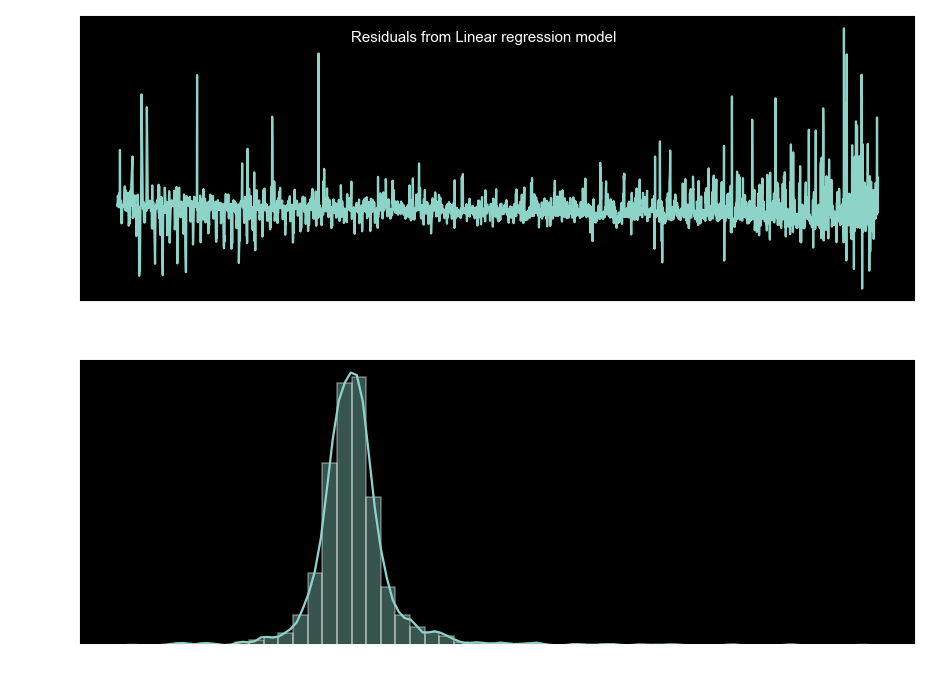

In [25]:
'''
Calculate and plot the residuals of the ols model
'''
fig = plt.figure(figsize=[15,10]);
    # subplots
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)
sns.distplot( mix_fit.resid,ax = ax2)
sns.lineplot( data = mix_fit.resid,ax = ax1)
plt.suptitle('Residuals from Linear regression model', size = 15);
plt.subplots_adjust(top=1)
print('The mean of the residuals are very close to zero : ',mix_fit.resid.mean())
print(mix_fit.resid.std())

The residual are very much normally distributed with a mean of $0$ and standard deviation of $3055$.

Lets look if there exists any correlation between the residuals and the regressors and regressand.

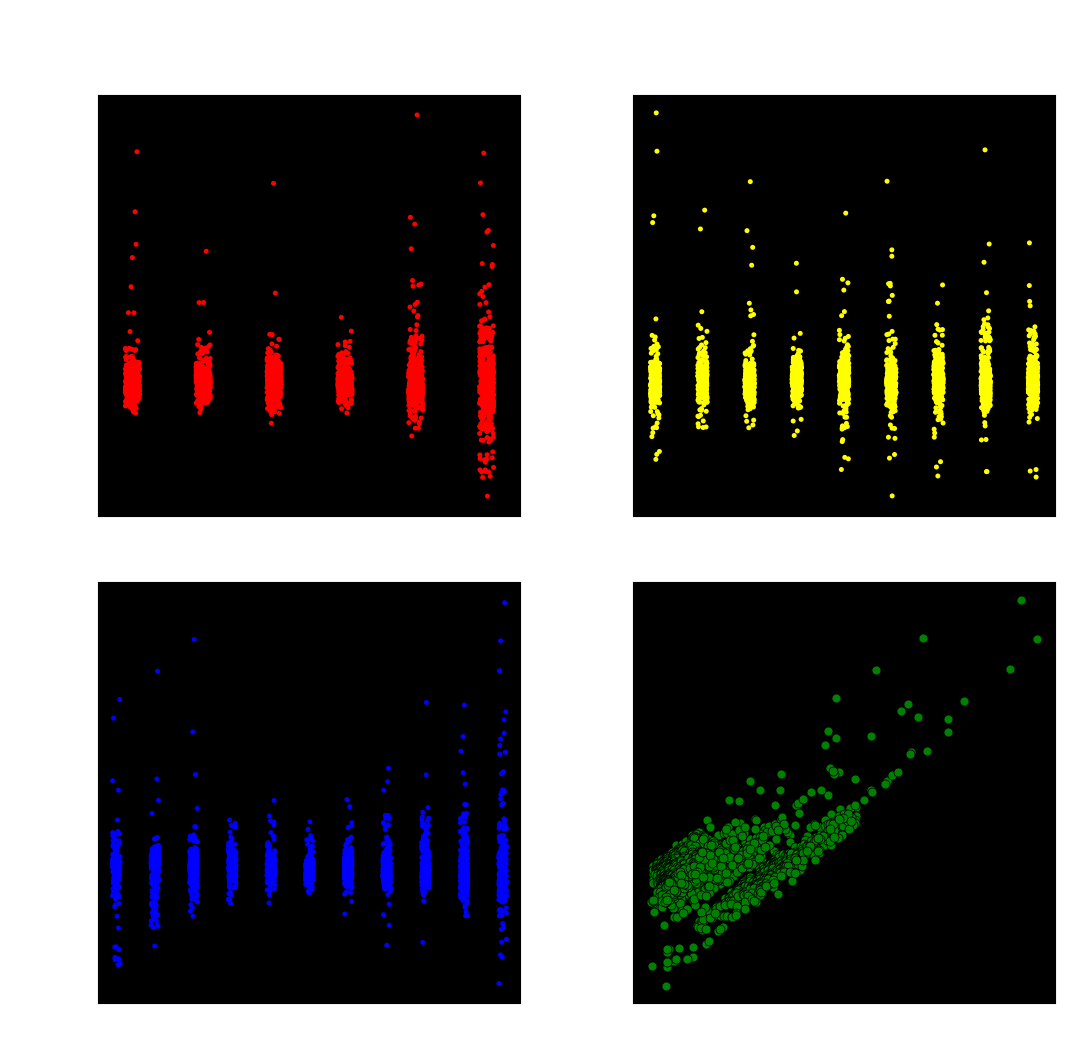

In [40]:
'''
Plot the residuals and regressors
'''

# figure window
fig = plt.figure(figsize=[15,15]);

# Education
sub1 = fig.add_subplot(221)
sns.stripplot(y = mix_fit.resid, x = groups.edu_cat,edgecolor = 'black',color = 'Red',ax = sub1)
#sub1.scatter(y = mix_fit.resid, x = groups.edu_cat)
sub1.set_xlabel('Education')
sub1.set_ylabel('Residuals');

# Province
sub2 = fig.add_subplot(222)
sns.stripplot(y = mix_fit.resid, x = groups.prov_cat ,edgecolor = 'black',color = 'Yellow',ax = sub2)

sub2.set_xlabel('Province')
sub2.set_ylabel('Residuals');

# Age
sub3 = fig.add_subplot(223)
sns.stripplot(y = mix_fit.resid, x = groups.Age ,edgecolor = 'black',color = 'Blue',ax = sub3)
sub3.set_xlabel('Age')
sub3.set_ylabel('Residuals');

# Salary
sub4 = fig.add_subplot(224)
sns.scatterplot(y = mix_fit.resid, x = groups.avg_sal ,edgecolor = 'black',color = 'Green',ax = sub4)
sub4.set_xlabel('Salary')
sub4.set_ylabel('Residuals');


fig.tight_layout()
fig.suptitle('Scatterplots of residuals versus each predictor', size = 14);
plt.subplots_adjust(top=0.9);

The residuals are randomly scatter around the mean of each of the variable but variation is present at the extreme points. Since the residuals are not correlated with the variable, the model coefficients are not biased. By looking at the 4th plot, the fitted values, we can check for heteroskedasticity. We see that as salary increase, the residuals do as well. This implies that the residuals are subject to the salary level. The fitted variable are thus heteroskedastic, which is not optimal. 


The regression model does not satisfy all of the below requirements:


- [x] **zero mean:** $E[\epsilon] = 0$
- [ ] **constant variance:** $Var(\epsilon_i) = \sigma^2$
- [ ] **uncorrelated errors:** $Cov(\epsilon_i,\epsilon_j) = 0 $
- [x] **uncorrelated to regressors:** $Cov(\epsilon_i, X) = 0 $
- [x] **Gaussian errors (not strictly required):** $\epsilon \sim N(0,\sigma)$ <br>

This model is hence not optimal. We have to explore other models to test the hypothesis.

# Hypothesis Testing

We will investigate the proportion of individuals that fall in the high income groups and test a hypothesis based on the observed proportions. If we achieve a p-value lower than 0.05 we can confidently say that the proportions of the tested groups are significant. I will verify my findings using bootstrap validation.

I will form groups based on the features in my dataset. The features are 1) Education 2) Province 3)Age. Each intersection of these feature will form a group. The groups will consist of the proportion of people in that group that falls in each income group.<br>
My Hypothesis test will compare the proportion of people in the follwing groups to the mean of the distribution:
-  Between age 45 and 64
-  Gauteng
-  Tertiary Education

Let $\vec{x} = [x_{0},x_{1},...,x_{18}$ are the proportions of the data under investigation. And $\vec{\mu} = [\mu_{0},\mu_{1},...,\mu_{18}$ be the mean proportions of the distribution. 

**Null Hypothesis** : The Proportions of the group under investigation is equal to that of the mean of the distribution.

$ \vec{x} = \vec{\mu}$

**Alternative Hypothesis** : The Proportions of the group under investigation is **not** equal to that of the mean of the distribution.

$ \vec{x} \neq \vec{\mu}$


In [27]:
'''
Read in Data and format the dataframes
'''

def norm_df(df,year):
    '''
    Normalizes the columns of a df
    '''
    sal_map = {'NONE':0,'none':0,'R1 - R200':100,'R201 - R500':250,'R501 - R1 000':750,'R1 001 - R1 500':1250,'R1 501 - R2 500':2000,'R2 501 - R3 500':3000,'R3 501 - R4 500':4000,'R4 501 - R6 000':5250,'R6 001 - R8 000':7000, 'R8 001 - R11 000':9500, 'R11 001 - R16 000':13500, 'R16 001 - R30 000':22500,'R30 001 - R37 500':32500, 'R37 501 - R54 167':45000,'R54 168 - R62 500':57500,'R62 501 - R70 800':66000,'R62 501- R70 800':66000,'R70 801 - R83 300':77500,'R83 301 or more':85000,'R83 301 OR MORE':85000}
    df.Salary = df.Salary.map(sal_map)
    df = df[df['Age']!= 'Total']
    df.columns = df.columns.map(str)
    df[year] = df[year]/df.groupby(by = ['Age','Province','Education'])[year].transform('sum')
    df['Age'] = df['Age'].apply(lambda x: '65' if x == 'Age 65+' else x)
    df['Age'] = df.Age.apply(lambda x: float(x[-2:]))
    df = df.groupby(by = ['Age','Province','Education','Salary']).sum().reset_index()
    new_df = df.copy(deep= True)
#     norm_df = ((df.divide(df[df.columns].max().values,axis = 'columns'))*100).reset_index()
#     norm_df = norm_df[norm_df['index'] != 'Total']
    return  new_df
mix_13n =norm_df(pd.read_excel('Data/mixed_2013.xlsx').fillna(method = 'ffill'),'2013')
mix_14n =norm_df(pd.read_excel('Data/mixed_2014.xlsx').fillna(method = 'ffill'),'2014')
mix_15n =norm_df(pd.read_excel('Data/mixed_2015.xlsx').fillna(method = 'ffill'),'2015')
mix_16n =norm_df(pd.read_excel('Data/mixed_2016.xlsx').fillna(method = 'ffill'),'2016')
mix_17n =norm_df(pd.read_excel('Data/mixed_2017.xlsx').fillna(method = 'ffill'),'2017')


mix_a = pd.concat([mix_17n,mix_16n,mix_15n,mix_14n,mix_13n])
mix_a = mix_a.melt(id_vars = ['Age','Education','Province','Salary'],var_name = ['year']).dropna()
mix_a = mix_a.drop_duplicates()

mixed = mix_a.groupby(by = ['Age','Education','Province','Salary']).sum().reset_index()
mixed['value'] = mixed['value']/5
mix_a.head()


,Age,Education,Province,Salary,year,value
44550,19.0,Less than primary completed,Eastern Cape,100.0,2013,0.000000
44551,19.0,Less than primary completed,Eastern Cape,250.0,2013,0.000000
44552,19.0,Less than primary completed,Eastern Cape,750.0,2013,0.566391
44553,19.0,Less than primary completed,Eastern Cape,1250.0,2013,0.290896
44554,19.0,Less than primary completed,Eastern Cape,2000.0,2013,0.049908


### Heatmap of the proportion of each subgroup in each salary group

<Figure size 864x864 with 0 Axes>

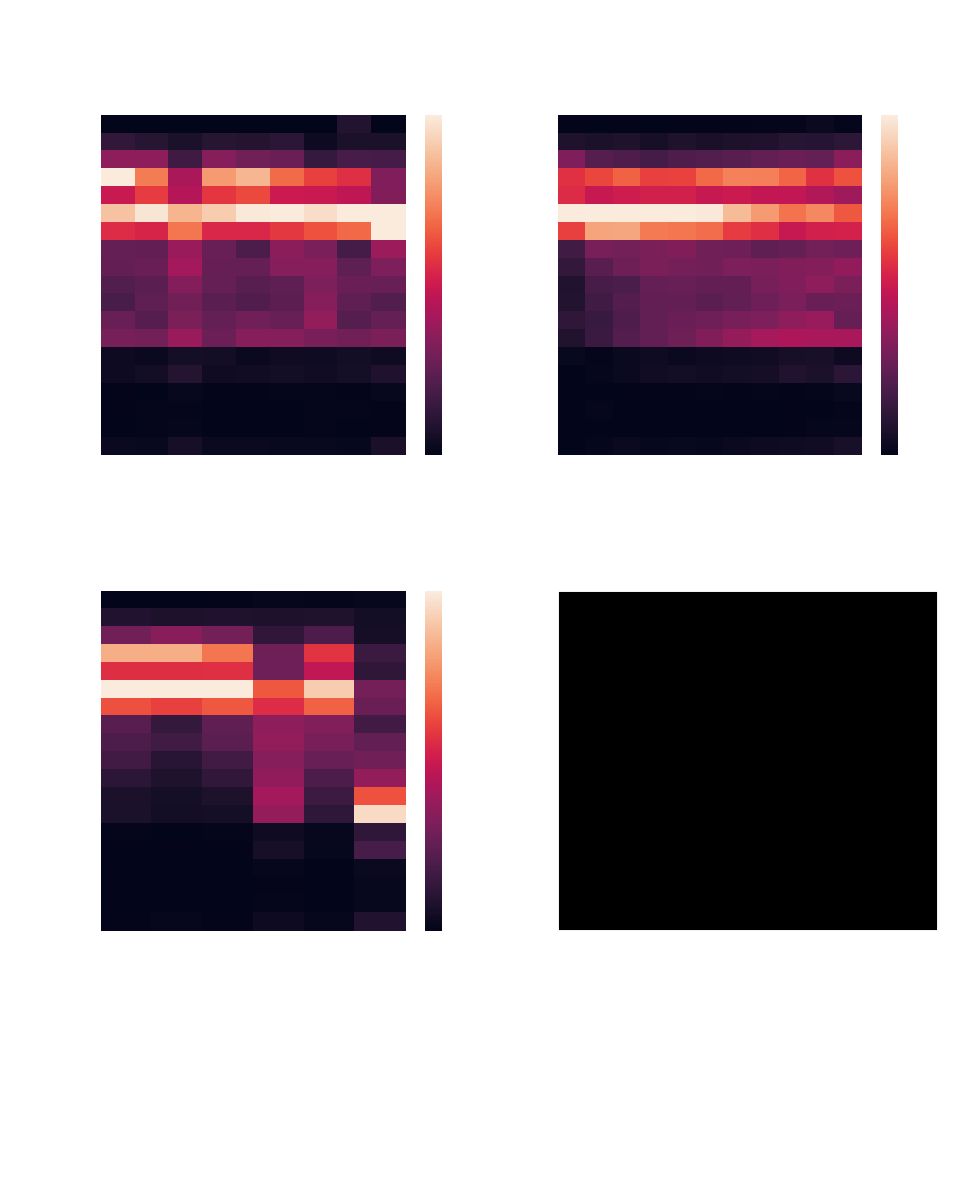

In [28]:
snsplota = mixed.groupby(by=['Age','Salary']).sum().reset_index()
snsplota = snsplota.pivot_table(values = 'value',columns = ['Age'],index = ['Salary'])
snsplota.columns = ['Age 15-19','Age 20-24','Age 25-29','Age 30-34'	,'Age 35-39','Age 40-44','Age 45-49','Age 50-54','Age 55-59','Age 60-64','Age 65+']

snsplotp = mixed.groupby(by=['Province','Salary']).sum().reset_index()
snsplotp = snsplotp.pivot_table(values = 'value',columns = ['Province'],index = ['Salary'])
snsplotp.columns = ['Eastern Cape','Free State','Gauteng','KwaZulu-Natal','Limpopo',	'Mpumalanga','North West','Northern Cape','Western Cape']

snsplote = mixed.groupby(by=['Education','Salary']).sum().reset_index()
snsplote = snsplote.pivot_table(values = 'value',columns = ['Education'],index = ['Salary'])



plt.figure(figsize = (12,12))
f, axes = plt.subplots(2, 2)
f.set_figheight(15)
f.set_figwidth(15)
f.suptitle('Heatmaps of the proportion in salary group')
sns.heatmap(data = snsplotp,robust = True,ax=axes[0][0]).set_title('Province')
sns.heatmap(data = snsplota,robust = True,ax=axes[0][1]).set_title('Age')
sns.heatmap(data = snsplote,robust = True,ax=axes[1][0]).set_title('Education')
plt.subplots_adjust(hspace =0.4);

The heatmap shows us that most people fall in the 5th and 6th income group. There are a few deviations though. We can see that the Tertiary education group has the most people in the highest 7th income group. If we look closely we can see that the ages between 50 and 65 has a large portion in the  7th income group. Gauteng and Western Cape also has larger portions in the higher income groups.

In [29]:
'''
Calculate the proportions of people in each group.
'''
reg_df = mix_a.copy()

grouptest = reg_df.groupby(by = ['Age','Education','Province','year'])
i = 0
alldata = []
max_len = 1
for name , group in grouptest:
    group = group.sort_values('Salary')
    vals = group['value'].values
    if len(group['value'].values) > max_len:
        max_len = len(group['value'].values)
    if len((group['value'].values)) < 19:
        n = len(group['value'].values)
        for i in range(19-n):
            vals = np.append(vals, 0)
    alldata.append(vals)

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    maxlen = 19

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z
all_data = np.array(alldata)
all_data = all_data.reshape(all_data.shape[0],19)


We need to select the data that we will test our hypothesis with. This will include people that satisfies the following:
-  Between age 45 and 64
-  Gauteng
-  Tertiary Education

In [30]:
'''
Select the data that will be used to test the hypothesis. This will consist of 1) people in the age of [45 - 65] 2) in Gauteng and a 3) Tertiary Education
'''
hyp_data = []
hyp_data.append(mix_a[(mix_a.Age == 64) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2017')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 64) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2016')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 64) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2015')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 64) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2014')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 64) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2013')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 59) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2017')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 59) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2016')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 59) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2015')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 59) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2014')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 59) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2013')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 54) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2017')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 54) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2016')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 54) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2015')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 54) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2014')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 54) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2013')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 49) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2017')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 49) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2016')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 49) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2015')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 49) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2014')  ].sort_values('Salary')['value'].values)
hyp_data.append(mix_a[(mix_a.Age == 49) & (mix_a.Education == 'Tertiary') & (mix_a.Province == 'Gauteng') & (mix_a.year == '2013')  ].sort_values('Salary')['value'].values)
hyp_data = pad_to_dense(np.array(hyp_data))


Below you can see the distribution of the proportion of people in each feature group that falls in each income group.

Text(0.5,1,'Distribution of proportion of people per income group')

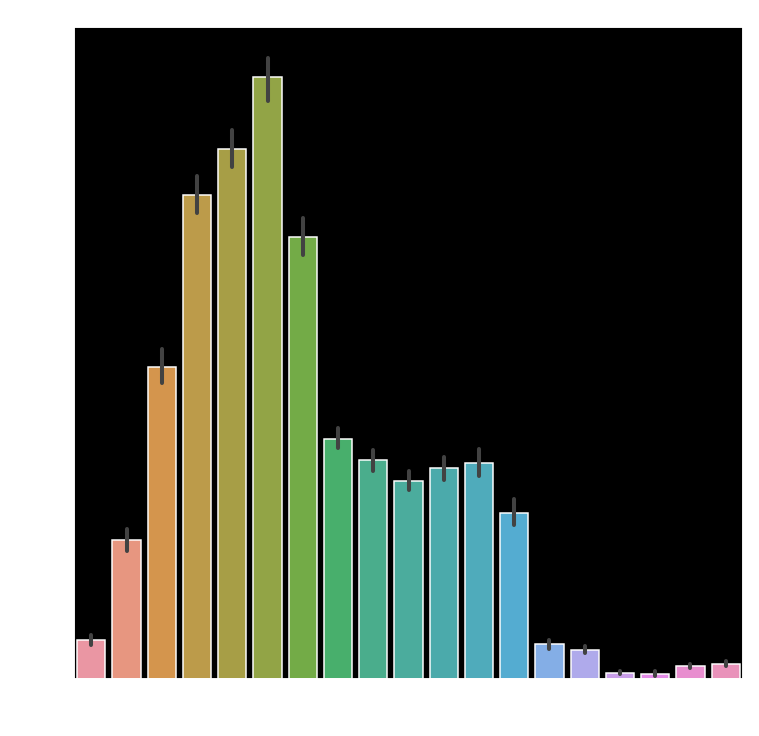

In [31]:
snsData = pd.DataFrame(all_data)
snsData = snsData.melt()
snsData.head()
plt.figure(figsize = (12,12))
sns.barplot(data = snsData, x = snsData.variable,y = snsData.value).set_title('Distribution of proportion of people per income group')

We can see that the distribution is normally distributed with the mode value at the 5th income group. This implies that amongst all groups, most people fall in the 5th income group. Now let us put the proportions to the test.

In [32]:
class proportion_test():
    '''
    Class that does proportional test.
    '''
    def __init__(self, data,expected,test_data):
        self.data = data
        self.MakeModel()
        self.expected = expected        
        self.test_data = test_data
        self.actual = self.TestStatistic(data)

    def PValue(self):
        iters = self.test_data.shape[0]
        self.test_stats = [self.TestStatistic(self.RunModel(i)) 
                           for i in range(iters-2)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, test_data):
        test_stat = sum(abs(test_data - self.expected))
        return test_stat

    def RunModel(self,i):
        freqs = self.test_data[i]
        return freqs
    def MakeModel(self):
        pass

The following test will test the proportions of the subgroups in my hypothesis agains the mean proportions of the distribution.

#### All Salary Group Proportions

In [33]:
'''
Test the hypothesis with all income groups
'''
all_data = np.array(alldata)
expected_prop = np.mean(all_data,axis = 0)

n = hyp_data.shape[0]
mean_p = 0
for i in range(n):
    dt = proportion_test(hyp_data[i],expected_prop,all_data)
    pvalue = dt.PValue()
    mean_p +=pvalue
mean_p = mean_p/n
print('The average p value for my hypothesis data i s: ' ,mean_p)

The average p value for my hypothesis data i s:  0.2445622895622896


We obtained a p value of 0.244 which is not considered significant.<br>
Since we are interested in the high income groups, lets us look at only the six highest income groups. 

#### Top six Salary Group Proportions

In [34]:
'''
Isolate the top 6 income groups and retest the hypothesis
'''

all_data4 = all_data[:,-6:]
hyp_data4 = hyp_data[:,-6:]
expected_prop4 =expected_prop[-6:]
n = hyp_data4.shape[0]
mean_p = 0
for i in range(n):
    dt = proportion_test(hyp_data4[i],expected_prop4,all_data4)
    pvalue = dt.PValue()
    mean_p +=pvalue
mean_p = mean_p/n
print('The average p value for my hypothesis data i s: ' ,mean_p)


The average p value for my hypothesis data i s:  0.029764309764309764


This is significantly lower than our previous p-value. The proportion of people in the high income groups in my selected subgroups is significant. We can confidently say that the proportion of people in high salary groups of older people in Gauteng with a teriary degree is statistically significant.  To confirm the significance of this result we should use bootstrap. The optimal parameters of the bootstrap algorithm will be found by investigation.

#### Bootstrap

The next test is using bootstrap with varying sample sizes tested on the top six income groups.

In [35]:
'''
A Bootstrap algorithm which is followed by a hypothesis test
'''

def bootstrap(data,rep,samplesize,test):
    pvalue = 0
    for j in range(rep):
        n = (data.shape[0]*samplesize)
        ran = (np.linspace(0,data.shape[0]-1,data.shape[0])).astype(int)
        selected = data[np.random.choice(ran,int(n))]
        sel_mean = np.mean(selected,axis = 0)
        mean_p = 0
        for i in range(test.shape[0]):
            dt = proportion_test(test[i],sel_mean,selected)
            p_value = dt.PValue()
            mean_p +=p_value
         
        pvalue += mean_p/(test.shape[0])
    pvalue = pvalue/rep
    return pvalue

for size in [0.5,0.6,0.7,0.8,0.9]:
    print(' p-value for bootstrap sample size :',size,' is : ',bootstrap(all_data4,40,size,hyp_data4))

 p-value for bootstrap sample size : 0.5  is :  0.030148989898989897
 p-value for bootstrap sample size : 0.6  is :  0.031386083052749716
 p-value for bootstrap sample size : 0.7  is :  0.030980038480038486
 p-value for bootstrap sample size : 0.8  is :  0.030098379629629635
 p-value for bootstrap sample size : 0.9  is :  0.029432285821174707


We can see that the pvalue remains more or less constant with variying sample size. Although the p value is still small, it is not significant. The smallest value is 0.075 with a sample size of 0.8. Lets see if we can achieve a significant result by altering the amount of income groups.


I have included the bottom salary groups in the test below to show that only the top income groups are significantly different.

In [42]:
print('p-values for varying number of top salary groups')
for i in [2,3,4,5,6,7,8,9,10]:
    all_data4 = all_data[:,-i:]
    hyp_data4 = hyp_data[:,-i:]
    print(' p-value for the top ',i,' income groups is : ',bootstrap(all_data4,40,0.8,hyp_data4))

print('p-values for varying number of bottom salary groups')
for i in [3,4,5,6,7,8]:
    all_data4 = all_data[:,:i]
    hyp_data4 = hyp_data[:,:i]
    print(' p-value for the bottom ',i,' income groups is : ',bootstrap(all_data4,40,0.8,hyp_data4))

p-values for varying number of top salary groups
 p-value for the top  2  income groups is :  0.03442918771043771
 p-value for the top  3  income groups is :  0.03204177188552189
 p-value for the top  4  income groups is :  0.033174978956228965
 p-value for the top  5  income groups is :  0.046085858585858584
 p-value for the top  6  income groups is :  0.030717592592592595
 p-value for the top  7  income groups is :  0.06286826599326599
 p-value for the top  8  income groups is :  0.059232428451178445
 p-value for the top  9  income groups is :  0.06556397306397307
 p-value for the top  10  income groups is :  0.07656092171717171
p-values for varying number of bottom salary groups
 p-value for the bottom  3  income groups is :  0.5400457702020198
 p-value for the bottom  4  income groups is :  0.4751672979797979
 p-value for the bottom  5  income groups is :  0.4395407196969696
 p-value for the bottom  6  income groups is :  0.4120764941077442
 p-value for the bottom  7  income groups

The top 6 income groups produced the lowest p-value. This p value is 0.03 which is considered significant. However all of the income groups above the 6th income group produces significant proportions. We can now be sure that the proportions of people in the subgroup - 1)*Older* peopl in 2) *Gauteng* with a 3) *Tertiary* education - is significant in any of the top 6 income groups. <br> By looking at the second test, we can see that the lower salary groups do not yield significant proportions as the higher salary groups do.
We can thus conclude by saying that most Older people in Gauteng with a Tertiary education fall in the top six income groups.

## Conclusion

In this inferential analysis we wanted to test the hypothesis that the subgroup of **Older people in Gauteng with a Tertiary education falls in the top salary groups.** 


I modelled the different features seperately with regression and combioned then in one model. In the regression models a clear relationship was present with the features under investigation. The subgroup in my hypothesis was responsible for most of the high income bracket predictions. The combined model performed satisfactory but was not optimal. The residuals' variance was not constant a correlation was present. I hence had to look at an alternative hypothesis test.

I proceeded to test the proportions of people in each salary group of the different subgroups. The null hypothesis is that the proportion of the subgroup under investigation is the same as the mean proportion of the distribution. <br>
The results of the test seemed promising after the first and second test. I initially tested the proportions of all the income groups and obtained a $p$ value of $0.24$.<br>

However, since I was only concerned with the top earners I reduced my test to only the top 6 income groups. The test resulted in a satisfactory  $p$ value of 0.029. According to this $p$ value, the proportions of **Older people in Gauteng with a Tertiary education** in the top six income groups are significantly different from the mean.<br>
To verify these results I used a bootstrap resampling approach with a train/test split of 0.8. This method resulted in a $p$ value of 0.03 for the top six income groups, which remains significant.<br>
To confirm that these proportions are only significant among the top earners, I tested the bottom income groups as well. This, as expected, did not produce any significant results. 

The results of tests performed is suficient evidences that the subgroup of **Older people in Gauteng with a Tertiary education falls in the top salary groups.** 